# Engineer A Dataset 👷‍♂️

This notebook contains the necessary steps to prepare the provided battery charging dataset for machine learning model training. The goal is to clean the data, engineer meaningful input features, and define a predictive target (charge duration). The final outcome will be two featurized datasets (training and test sets), saved in csv format, which will be used in future model training iterations.

## Import Libraries 📚
**STEP ONE:** Import the libraries nessecary for Data Preparation
* Turitrove for data collection
* Matplotlib for data visualization
* Seaborn for data visualization
* OS for directory searching
* Pandas for data manipulation
* Numpy for conditional row selection
* Zipfile for unzipping data

In [2]:
import turitrove as trove
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pandas as pd
import numpy as np
import zipfile
import tqdm as tqdm

# Hide Warnings
import warnings
warnings.filterwarnings("ignore")

---
## Mount the Data

**STEP 2**: Mount the [aiedu_battery_charging dataset](https://trove.apple.com/dataset/aiedu_battery_charging/1.0.0) from Trove, and read it in as a pandas DataFrame. 


In [3]:
# provided un-mount step 
trove.umount('dataset/aiedu_battery_charging@1.0.0')

## TODO: Mount the dataset
URI = 'dataset/aiedu_battery_charging@1.0.0'
if not os.path.isdir('data'):
    os.makedirs('data')

trove.download(URI, 'data')

dataset/aiedu_battery_charging@1.0.0 is not mounted
Download in progress: /Users/noahgallego/Desktop/Apple ML Program/Engineering_Data/data/aiedu_battery_charging-1.0.0/data
Download started...
Download completed. Checkout /Users/noahgallego/Desktop/Apple ML Program/Engineering_Data/data/aiedu_battery_charging-1.0.0/data for your files


In [4]:
## Define a path for finding the specific raw data file
zip_path = '/Users/noahgallego/Desktop/Apple ML Program/Engineering_Data/data/aiedu_battery_charging-1.0.0/data/raw.zip'
base = '/Users/noahgallego/Desktop/Apple ML Program/Engineering_Data/data/aiedu_battery_charging-1.0.0/data'
data_path = base + '/raw/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

data_path += os.listdir(data_path)[0]

## Read in the path as a pandas dataframe
df = pd.read_csv(data_path)

---
## Initial Explorations

**STEP THREE:** Take a look at the data and understand the structure

In [5]:
# Take a look at the first few rows
print(df.shape)
df.head()

(41195667, 5)


,start,end,stream,value,user_id
0,2020-03-03 00:00:00,2020-03-03 00:13:00,/device/batteryPercentage,73.0,cd8014ee-5e62-4e41-9c24-de50178b4a97
1,2020-03-03 00:13:00,2020-03-03 00:26:00,/device/batteryPercentage,72.0,cd8014ee-5e62-4e41-9c24-de50178b4a97
2,2020-03-03 00:26:00,2020-03-03 00:26:00,/device/batteryPercentage,71.0,cd8014ee-5e62-4e41-9c24-de50178b4a97
3,2020-03-03 00:26:00,2020-03-03 00:27:00,/device/batteryPercentage,70.0,cd8014ee-5e62-4e41-9c24-de50178b4a97
4,2020-03-03 00:27:00,2020-03-03 00:27:00,/device/batteryPercentage,69.0,cd8014ee-5e62-4e41-9c24-de50178b4a97


## Data formatting

**STEP 4**: Check the data formats, using the `.dtypes` attribute for a DataFrame.

In [6]:
## TODO: Identify the type of data in each column, what seems right or wrong?
df.dtypes

start       object
end         object
stream      object
value      float64
user_id     object
dtype: object

**STEP 5:** Convert or read in the data such that dates and numeric values are correctly typed.
```
start      datetime64[ns]
end        datetime64[ns]
stream             object
value             float64
user_id            object
dtype: object
```


In [7]:
# Convert to PD Datetime Obj
df['start']= pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

## Convert Value Col to Numeric
df['value'] = pd.to_numeric(df['value'])

## Verify Changes
df.dtypes

start      datetime64[ns]
end        datetime64[ns]
stream             object
value             float64
user_id            object
dtype: object

## Data Exploration
**STEP 5:** Perform initial exploration and answer questions about the dataset:
<br />
*1. Number of User Devices (ID's)*
<br />
*2. Data Collection Date-Range*
<br />
*3. NA Values*
<br />
*4. Average Charge Time*

In [8]:
# 1. Get list of unique devices
unique_user = df['user_id'].unique()
print("The number of unique devices in the dataset are: ", len(unique_user)) 

# 2. Get earliest and latest date from the dataset
earliest = df['start'].min()
latest = df['end'].max()

print("\nOur study collects data from devices from ", earliest, " to ", latest, ".")

# 3. How long do users typically charge their devices?
plugin_df = df.copy()

plugin_df['charging_time'] = np.where(
    (plugin_df['stream'] == "/device/isPluggedIn") & (plugin_df['value'] == 1.0),
    (plugin_df['end'] - df['start']).dt.total_seconds() / 60,
    np.nan  # Setting charging time to 0 for rows that are not charging
)

# 4. Locate any NA Values
plugin_df = plugin_df.dropna()
plugin_df.reset_index(inplace = True)
plugin_df = plugin_df.drop('index', axis = 'columns')

The number of unique devices in the dataset are:  10150

Our study collects data from devices from  2020-03-02 00:00:00  to  2070-08-30 02:51:00 .


In [9]:
plugin_df.head()

,start,end,stream,value,user_id,charging_time
0,2020-03-03 04:53:00,2020-03-03 05:32:00,/device/isPluggedIn,1.0,cd8014ee-5e62-4e41-9c24-de50178b4a97,39.0
1,2020-03-03 07:20:00,2020-03-03 16:59:00,/device/isPluggedIn,1.0,cd8014ee-5e62-4e41-9c24-de50178b4a97,579.0
2,2020-03-04 05:02:00,2020-03-04 05:51:00,/device/isPluggedIn,1.0,cd8014ee-5e62-4e41-9c24-de50178b4a97,49.0
3,2020-03-04 07:30:00,2020-03-04 07:30:00,/device/isPluggedIn,1.0,cd8014ee-5e62-4e41-9c24-de50178b4a97,0.0
4,2020-03-04 07:30:00,2020-03-04 13:30:00,/device/isPluggedIn,1.0,cd8014ee-5e62-4e41-9c24-de50178b4a97,360.0


## Further Exploration:
**STEP 6:** Find number of iPhones that are charging in the dataset vs ones that are not

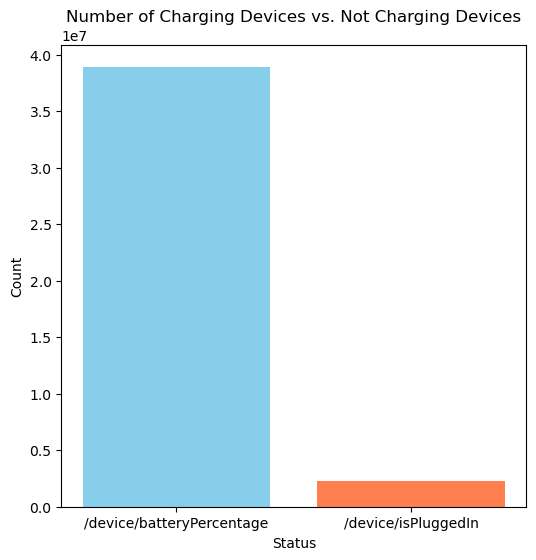

In [10]:
# Print number of iPhones that are charging
status_counts = df['stream'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(status_counts.index, status_counts.values, color=['skyblue', 'coral'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Number of Charging Devices vs. Not Charging Devices')
plt.show()

In [11]:
# Check for missing values in start and end
charging_mean = plugin_df['charging_time'].mean()
print("Mean Charging Time (in minutes):", np.round(charging_mean))

Mean Charging Time (in minutes): 278.0



**Step 7:** What times of day are users most likely to plug in their devices and leave them plugged in for a long time (over 3hrs)?

In [32]:
# selecting by stream and value
plug_in_condition = (df['stream'] == "/device/isPluggedIn") & (df['value'] == 1.0)
plugin_df = df[plug_in_condition].copy()

# calculate the duration (in minutes) of a plugin event, and add it as a new column
# dt.total_seconds converts an amount of time into seconds and then dividing by 60 gives minutes
plugin_df['duration_mins'] = (plugin_df['end'] - plugin_df['start']).dt.total_seconds() / 60

# selecting by >= 3hr durations
long_charge_condition = plugin_df['duration_mins'] >= 60*3  # 3 hrs in minutes
long_charges = plugin_df[long_charge_condition].copy()

# check work so far, should see only long plugged-in events
long_charges.reset_index(inplace = True)
long_charges = long_charges.drop('index', axis = 'columns')

# Display first few rows
long_charges.head()

,start,end,stream,value,user_id,plug_in_hour,day_of_week,time_since_last_charge,duration_mins
0,2020-03-02 03:28:00,2020-03-02 09:09:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,3,0,0.000000,341.0
1,2020-03-02 10:35:00,2020-03-02 13:47:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,10,0,0.016667,192.0
2,2020-03-02 23:43:00,2020-03-03 02:57:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,23,0,0.050000,194.0
3,2020-03-03 05:00:00,2020-03-03 14:09:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,5,1,0.000000,549.0
4,2020-03-06 10:43:00,2020-03-06 16:36:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,10,4,0.016667,353.0


(array([ 9217.,  6383.,  5168.,  4604.,  4086.,  4008.,  3786.,  3930.,
         3981.,  3831.,  3990.,  4358.,  5015.,  6284.,  7536.,  9028.,
         9041.,  7318.,  5843.,  5285.,  5756.,  7416., 10989., 13005.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

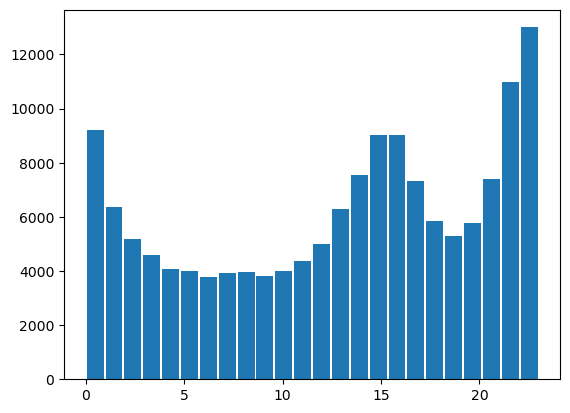

In [33]:
# first extract the starting hr and save in a column
long_charges['start_hr'] = long_charges['start'].dt.hour
plt.hist(long_charges['start_hr'], bins=24, rwidth=0.9) # 24 bins for 24 hrs, 0.9 spacing for visual distinction

## Battery Level Trends By User 📈

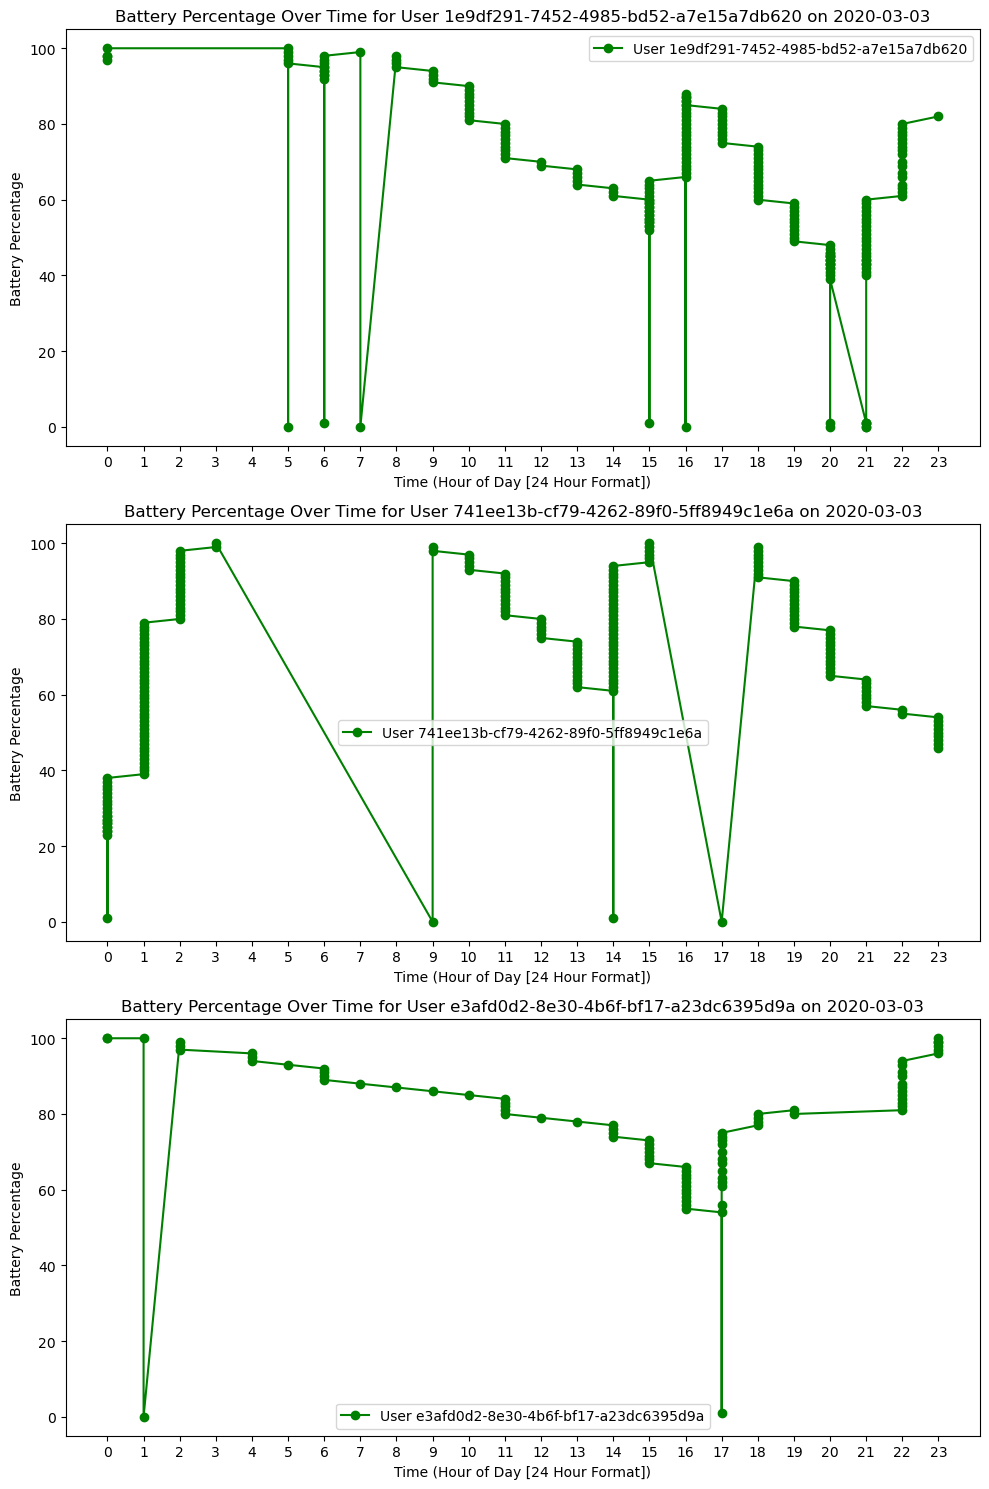

In [34]:
# Select a specific day, e.g., '2020-03-03'
selected_day = '2020-03-03'
day_filtered_df = df[df['start'].dt.date == pd.to_datetime(selected_day).date()]

# Group by user_id
grouped = day_filtered_df.groupby('user_id')

# Randomly select a few users to plot (only from users available on that day)
np.random.seed(42)  # For reproducibility
available_users = day_filtered_df['user_id'].unique()
random_users = np.random.choice(available_users,
                                size=min(3,
                                len(available_users)),
                                replace=False)

# Create subplots for each selected user
fig, axes = plt.subplots(nrows=len(random_users), ncols=1, figsize=(10, 15))

for i, user_id in enumerate(random_users):
    user_data = grouped.get_group(user_id)
    axes[i].plot(user_data['start'].dt.hour, user_data['value'], label=f'User {user_id}', color='g', marker = 'o')
    axes[i].set_xlabel('Time (Hour of Day [24 Hour Format])')
    axes[i].set_ylabel('Battery Percentage')
    axes[i].set_title(f'Battery Percentage Over Time for User {user_id} on {selected_day}')
    axes[i].legend()
    axes[i].set_xticks(range(24))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## How Often do Users Charge their device to full? *(100%)* ⏰

In [35]:
full_charge = df[df['value'] == 100]
users_fully_charged = full_charge['user_id'].nunique()

print(f"Number of users that charged their phone to 100% at least once: {users_fully_charged}")

Number of users that charged their phone to 100% at least once: 10046


## Feature Creation 🛠️🔋

In [37]:
# Sort the DataFrame for correct sequence of events
plugin_df = plugin_df.sort_values(by=['user_id', 'start']).reset_index(drop=True)

# Average Charging Duration By User
average_duration = plugin_df.groupby('user_id')['duration_mins'].mean().reset_index()
average_duration.rename(columns={'duration_mins': 'average_duration'}, inplace=True)

# Charging Frequency / Day per user
plugin_df['day'] = plugin_df['start'].dt.date
charging_frequency = plugin_df.groupby(['user_id', 'day']).size().reset_index(name='charging_frequency_per_day')

# Time of day feature (hour of plug-in)
plugin_df['plug_in_hour'] = plugin_df['start'].dt.hour

# Assuming df is your DataFrame
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Extract hour of plug-in (from 'start' timestamp)
df['plug_in_hour'] = df['start'].dt.hour

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['start'].dt.dayofweek

# Calculate the time since last charging session (in hours)
df = df.sort_values(by=['user_id', 'start']).reset_index(drop=True)
df['time_since_last_charge'] = df.groupby('user_id')['start'].diff().dt.total_seconds() / 3600

# Handle NaN values for the first session (as there's no prior session to calculate the difference)
df['time_since_last_charge'].fillna(0, inplace=True)

# Display the updated DataFrame
plugin_df.head()

,start,end,stream,value,user_id,plug_in_hour,day_of_week,time_since_last_charge,duration_mins,day
0,2020-03-02 00:48:00,2020-03-02 01:47:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,0,0,0.016667,59.0,2020-03-02
1,2020-03-02 01:48:00,2020-03-02 01:48:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,1,0,0.016667,0.0,2020-03-02
2,2020-03-02 01:48:00,2020-03-02 02:22:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,1,0,0.000000,34.0,2020-03-02
3,2020-03-02 03:16:00,2020-03-02 03:22:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,3,0,0.200000,6.0,2020-03-02
4,2020-03-02 03:28:00,2020-03-02 09:09:00,/device/isPluggedIn,1.0,000b1ca1-43be-435c-92e1-d694c40e703f,3,0,0.000000,341.0,2020-03-02


In [53]:
# Merge the features back into the original dataset or a new DataFrame for training
features_df = plugin_df.merge(average_duration, on='user_id')
features_df = features_df.merge(charging_frequency, on=['user_id', 'day'])

# Re-Organize DF (ensure the columns exist correctly)
# print(features_df.columns) # Uncomment to inspect column names
features_df.rename(columns={'duration_mins': 'charge_duration_mins'}, inplace=True)

features_df = features_df.drop(['start', 'end', 'stream', 'user_id', 'day'], axis=1)

# Move 'charge_duration_mins' to the last column
columns = list(features_df.columns)
columns.remove('charge_duration_mins')
columns.append('charge_duration_mins')
features_df = features_df[columns]

# Save The Dataset for Machine Learning!! 💻🧠

Let's save and evaluate!

In [54]:
features_df.head()

,value,plug_in_hour,day_of_week,time_since_last_charge,average_duration,charging_frequency_per_day,charge_duration_mins
0,1.0,0,0,0.016667,70.832335,10,59.0
1,1.0,1,0,0.016667,70.832335,10,0.0
2,1.0,1,0,0.000000,70.832335,10,34.0
3,1.0,3,0,0.200000,70.832335,10,6.0
4,1.0,3,0,0.000000,70.832335,10,341.0


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = features_df[columns[:-1]]
y = features_df[columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(
  X, y, random_state=104, test_size=0.25, shuffle=True)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 6073888242.516714
R-squared: 0.06709295825897432


In [57]:
# The model isn't capturing non-linearity (expected) so we will have to try more advanced methods. 
# Save the data :)

features_df.to_csv('Data/Output/engineered_dataset.csv', index = False)